In [178]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Sphere = lambda x: np.linalg.norm(x)**2
class FHO():
    """ Class for FHO 
    ---------
    self.cost_function: fucntion to optimize
    self.candidates : List of Candidates
    self.d: dimension of the problem
    self.Fhawks : list of fire hawks
    self.preys : list of preys
    self.territories : territory of each hawk
    self.N : Number of solution candidates (int)
    self.minD : numpy array of dimension (d,) containing the MIN value for each variable
    self.maxD : numpy array of dimension (d,) containing the MAX value for each variable
    self.N : Number of solution candidates (int)
    self.maxIter: Maximum number of iterations (int)
    self.best_costs: list of best costs
    """
    
    def __init__(self, minD , maxD, N, function , max_iter=200):
        self.max_iter      = max_iter
        self.minD          = minD
        self.maxD          = maxD
        self.cost_function = function
        self.N             = N
        self.d             = len(minD) #Number of decision variables
        self.Xcandidates   = np.random.uniform(minD,maxD,(N,self.d)) 
        self.best_costs    = []
        self.costs_iter    = []
        self.minimal_p     = None
        
        
    def territories(self,Fhawks,Preys):
        #Computing territories using the euclidien distance
        preys_left=Preys.copy()
        territories={i:np.array([]) for i in range(len(Fhawks))}
        for i in range(len(Fhawks)):
            #distance with respect to Fire hawk i           
            D=np.linalg.norm(Fhawks[i]-preys_left,axis=1)
            
            #Get territory of fire Hawk i 
            sorted_preys_idx=np.argsort(D)
            alpha=np.random.randint(1,len(preys_left)-1) if len(preys_left)-1>1 else 1
            my_preys=sorted_preys_idx[:alpha]
            # print("preys_left",len(preys_left))
            # print("alpha",alpha)
            # print("myprevs",len(my_preys))
            # print("slice",len(preys_left[my_preys]))
            territories[i]=preys_left[my_preys]
            preys_left=preys_left[sorted_preys_idx[alpha:]]          
            if len(preys_left)==0:
                break
        if len(preys_left)>0:
            territories[len(Fhawks)-1]=np.array(list(territories[len(Fhawks)-1])+list(preys_left))
        return territories
            
                      
    def minimize_FHO(self):
        ## Fire hawk algorithm to minimize the cost function       
        
        d=self.d
        Xcandidates=self.Xcandidates
        N=self.N
        max_iter = self.max_iter  
        minD=self.minD
        maxD=self.maxD
        Costfunction = self.cost_function
        
        #Evaluate the cost function for all candidate vectors
        Cost= np.array([Costfunction(Xcandidates[i]) for i in range(N)])
        
        #Randomly set a number of Hawks between 1 and 20% of N
        num_Hawks = np.random.randint(1,int(N/5)+1) if 1<int(N/5)+1 else 1
        
        #Ordering candidates
        Xcandidates = Xcandidates[np.argsort(Cost)]
        Cost.sort()
        SP=Xcandidates.mean(axis=0)
         
        
        #Select fire hawks
        Fhawks= Xcandidates[:num_Hawks]
        
        #Select the Preys dim(N-num_Hawks,d)
        Preys = Xcandidates[num_Hawks:]
        
        #get territories
        territories=self.territories(Fhawks,Preys)
        
        #update best
        GB=Cost[0]
        Best_Hawk=Xcandidates[0]

        #Counter
        FEs=N

        ## Main Loop
        #for _ in tqdm(range(max_iter)):
        while FEs < max_iter:
            PopTot=[]
            Cost=[]
            #Movement of Fire Hawk for all territories
            for i in territories:
                PR=territories[i].copy()
                FHl=Fhawks[i].copy()
                SPl=PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a,b=np.random.uniform(0,1,size=2)
                FHnear  =Fhawks[np.random.randint(num_Hawks)]                 
                FHl_new =FHl+(a*GB-b*FHnear)
                FHl_new = np.maximum(FHl_new,minD)
                FHl_new = np.minimum(FHl_new,maxD)
                PopTot.append(list(FHl_new))
                
                #Movement of the preys following Fire Hawks movement
                for q in range(len(PR)): 
                    a,b=np.random.uniform(0,1,size=2)
                    PRq_new1=PR[q].copy()+((a*FHl-b*SPl))
                    PRq_new1= np.maximum(PRq_new1,minD)
                    PRq_new1 = np.minimum(PRq_new1,maxD)
                    PopTot.append(list(PRq_new1))
                    
                    #Movement of the preys outside of territory
                    a,b      =np.random.uniform(0,1,size=2)
                    FHAlter  =Fhawks[np.random.randint(num_Hawks)] 
                    PRq_new2 =PR[q].copy()+((a*FHAlter-b*SP));
                    PRq_new2 = np.maximum(PRq_new2,minD)
                    #The following line for PRq_new2 differs from original algorithm in matlab code (max instead of min):
                    # Effects observed through our testing:
                    # 1/ It converges faster and the costs of the subsequent iterations will tend to decrease (less chaotic behavior than with np.minimun)
                    # 2/ In higher dimensions, it converge to the right solution! (while with np.minimum it does not)
                    PRq_new2 = np.maximum(PRq_new2,maxD)
                    PopTot.append(list(PRq_new2))
                             
            #Get cost
            PopTot=np.array(PopTot)
            for i in range(len(PopTot)):
                Cost.append(Costfunction(PopTot[i]))
                FEs = FEs+1
     
            #Create a new population of Hawks and Preys
            order_idx=np.argsort(Cost)
            Cost.sort()
            PopTot=np.array(PopTot)[order_idx]
            num_Hawks = np.random.randint(1,int(N/5)+1) if 1<int(N/5)+1 else 1
            BestPop=PopTot[0]
            SP=PopTot.mean(axis=0)
            Fhawks=PopTot[:num_Hawks]
            Preys=PopTot[num_Hawks:]          
               
            #Get territories
            territories=self.territories(Fhawks,Preys)
           
            # Update Global Best Cost (if relevant) 
            if Cost[0]<GB:
                BestPos=BestPop
                GB=Cost[0]
                self.best_costs.append(GB)
                self.minimal_p=Fhawks[0]
            else:
                self.best_costs.append(GB)
           
            #Track the iteration calculated cost
            self.costs_iter.append(Cost[0])

        #Return Global Best and argmin
        return (GB,self.minimal_p)
            
    def plot_costs(self):
        #Plot cost evolution
        vals=self.costs_iter
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Iteration Cost")
        plt.plot(np.arange(n),vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()



<h1>1. Sphere</h1>

Below are plots of the Sphere function in 2-Dimensions.

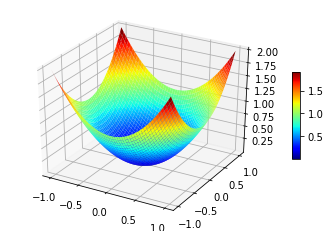

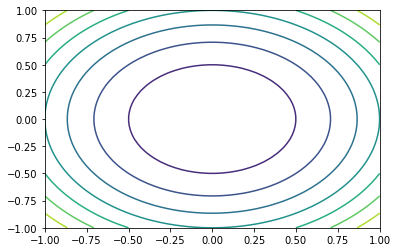

In [179]:
def f(x1,x2):
  a= x1**2+x2**2
  return a
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>1.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the sphere in 2-Dimensions.

As seen in above plot, the minimum is f(x) = 0 and it is obtained for (x,y)=(0,0).

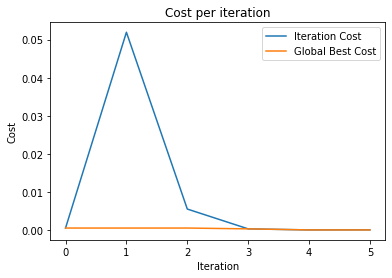

(4.899753572137474e-06, array([0.00135763, 0.00174831]))

In [180]:
fonction=lambda x : np.linalg.norm(x)**2

minD=[-5,-5]
maxD=[5,5]

opti=FHO(minD , maxD, N=200, function = fonction, max_iter=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>1.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the sphere in 25-Dimensions. We ran it on a range [-100,100] for each axis.

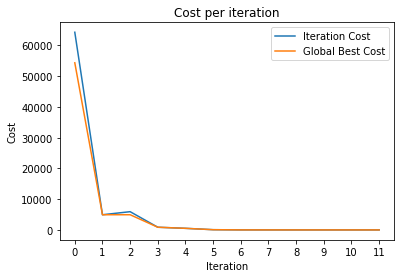

(0.0026347785234217855,
 array([-0.00949807, -0.01506828, -0.0064669 , -0.01167838, -0.01107553,
         0.0013004 , -0.00577605, -0.0037393 , -0.00694045, -0.00661801,
        -0.01082267, -0.02429388, -0.00292018, -0.00921832, -0.01379226,
        -0.00676255, -0.00101181, -0.00612459, -0.01078444, -0.01487645,
        -0.01801336, -0.00421215, -0.00334397, -0.00866946, -0.00584269]))

In [181]:
fonction=lambda x : np.linalg.norm(x)**2

minD=np.ones(25)*-100
maxD=np.ones(25)*100

opti=FHO(minD , maxD, N=30, function = fonction, max_iter=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>2. Exponential</h1>

Below are plots of the Exponential function in 2-Dimensions.

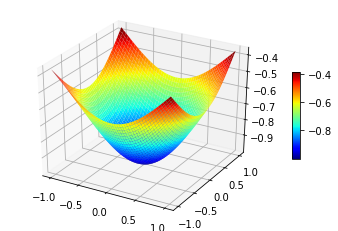

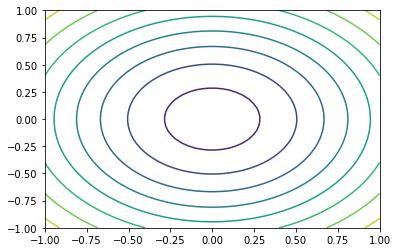

In [182]:
def f(x1,x2):
  a= -np.exp(-0.5*(x1*x1 + x2*x2))
  return a
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>2.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the exponential in 2-Dimensions.

As seen in above plot, the minimum is f(x) = -1 and it is obtained for (x,y)=(0,0).

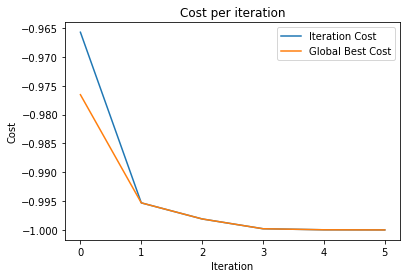

(-0.9999837781684152, array([0.00427987, 0.00375855]))

In [183]:
exponential = lambda x: -np.exp(-0.5*np.sum(x**2))

minD=[-5,-5]
maxD=[5,5]

opti=FHO(minD , maxD, N=200, function = exponential, max_iter=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>2.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the exponential in 25-Dimensions. We ran it on a range [-30,30] for each axis.

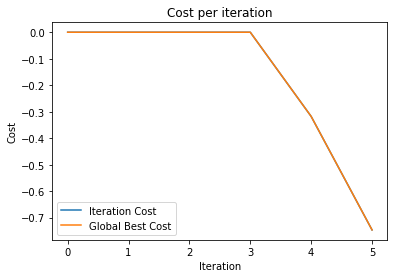

(-0.7463383616738059,
 array([-0.1536072 , -0.02940026, -0.14777296, -0.17805826, -0.22850616,
         0.13149926, -0.12619383, -0.17980531, -0.03210588, -0.17205404,
        -0.14892325, -0.14775378, -0.37607158, -0.13851054, -0.13192294,
         0.01266197, -0.11075345, -0.1708031 , -0.12253164, -0.17364736,
        -0.08650074, -0.04604521, -0.04932476, -0.07670122, -0.17900187]))

In [184]:
exponential = lambda x: -np.exp(-0.5*np.sum(x**2))

minD=np.ones(25)*-30
maxD=np.ones(25)*30

opti=FHO(minD , maxD, N=200, function = exponential, max_iter=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>3. Ackley</h1>

Below are plots of the Ackley function in 2-Dimensions.

The Ackley function is non-convex, which could be a challenge for some algorithms.

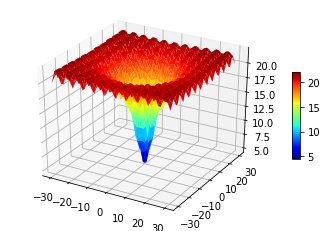

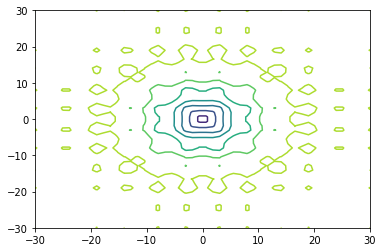

In [185]:
def f(x,y):
  return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))-np.exp(0.5 * (np.cos(2 * np.pi * x)+np.cos(2 * np.pi * y))) + np.e + 20
 

x1= np.linspace(-30,30)
x2= np.linspace(-30,30)
x, y = np.meshgrid(x1, x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>3.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the ackley in 2-Dimensions.

As seen in above plot, the minimum is f(x) = 0 and it is obtained for (x,y)=(0,0).

The Ackley function has many local minimas but the algorithm do not get stuck.

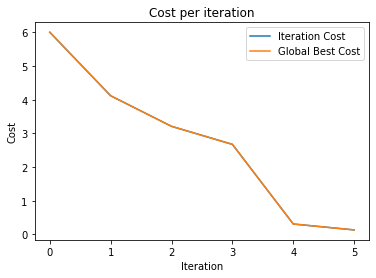

(0.131927198905899, array([-0.02773579, -0.02155074]))

In [186]:
def ackley(x):
  sumsquares= np.sum(x**2)
  sumcos = np.sum(np.cos(2 * np.pi * x))
  return -20.0 * np.exp(-0.2 * np.sqrt(1/len(x) * sumsquares))-np.exp(1/len(x) * sumcos) + np.e + 20

minD=[-30,-30]
maxD=[30,30]

opti=FHO(minD , maxD, N=200, function = ackley, max_iter=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>3.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the Ackley in 25-Dimensions. We ran it on a range [-30,30] for each axis.

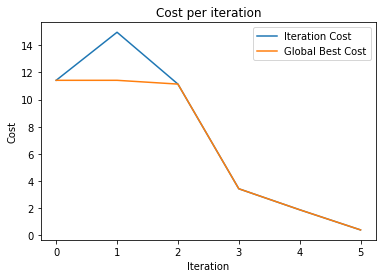

(0.40439947259645237,
 array([0.0615368 , 0.05965129, 0.07389421, 0.06444944, 0.02847422,
        0.04579481, 0.06505769, 0.05549043, 0.06595472, 0.03189395,
        0.07037187, 0.07180737, 0.0611142 , 0.04281784, 0.07566758,
        0.06079755, 0.05607742, 0.0427378 , 0.03302904, 0.06195903,
        0.06593074, 0.07922224, 0.0384479 , 0.03742526, 0.05880331]))

In [187]:
def ackley(x):
  sumsquares= np.sum(x**2)
  sumcos = np.sum(np.cos(2 * np.pi * x))
  return -20.0 * np.exp(-0.2 * np.sqrt(1/len(x) * sumsquares))-np.exp(1/len(x) * sumcos) + np.e + 20

minD=np.ones(25)*-30
maxD=np.ones(25)*30

opti=FHO(minD , maxD, N=200, function = ackley, max_iter=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>4. Becker-lago</h1>

Below are plots of the Becker-lago function in 2-Dimensions.


$$f(X)=(|x1|−5)^2+(|x2|−5)^2$$

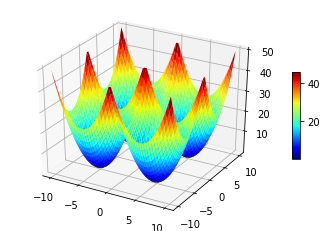

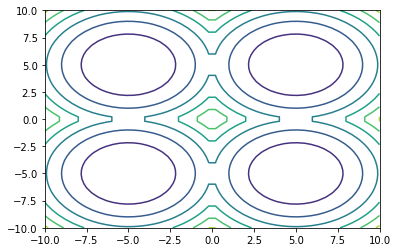

In [188]:
def f(x,y):
  return (np.abs(x)-5)**2+(np.abs(y)-5)**2
 
x1= np.linspace(-10,10)
x2= np.linspace(-10,10)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>4.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the Becker-Lago in 2-Dimensions.

As seen in above plot, the Becker-Lago is non convex, non differentiable and it has 4 minimum solutions such that $f(x) = 0$ for: 
$$$$

$$(x,y) \in \{(-5,-5),(-5,5),(5,-5),(5,5)\}$$

The below code converge towards any of the minimums.

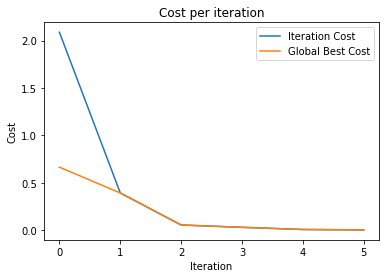

(0.0016762674584828428, array([5.02220881, 5.03439529]))

In [189]:
def becker_lago(x):
  return np.sum((np.abs(x)-5)**2)

minD=[-30,-30]
maxD=[30,30]

opti=FHO(minD , maxD, N=200, function = becker_lago, max_iter=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>4.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the Becker-Lago in 25-Dimensions. We ran it on a range [-30,30] for each axis.

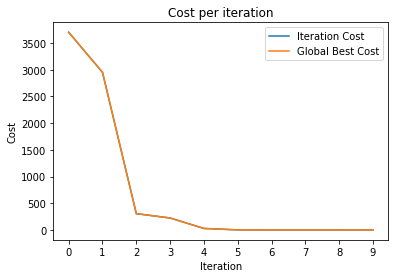

(0.02952804907395829,
 array([-4.97559446, -5.05008016, -4.99010621, -4.98300532, -5.0217515 ,
        -4.98832259, -5.0908177 , -4.94490876, -5.02634676, -4.97660557,
        -4.97218235, -5.01705663, -4.96908574, -4.97267914, -4.98171394,
        -4.99711317, -4.97773016, -4.97866124, -4.93485484, -4.97763176,
        -4.96707733, -4.97256462, -4.98387105, -4.95525767, -4.99964768]))

In [190]:
def becker_lago(x):
  return np.sum((np.abs(x)-5)**2)

minD=np.ones(25)*-100
maxD=np.ones(25)*100

opti=FHO(minD , maxD, N=200, function = becker_lago, max_iter=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>5. Bird function</h2>



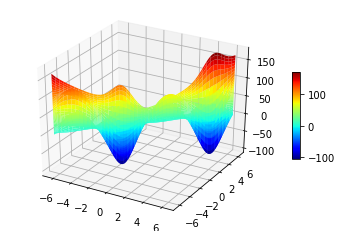

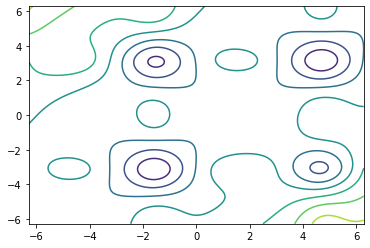

In [191]:
def f(x,y):
 return np.sin(x)*(np.exp(1-np.cos(y))**2)+np.cos(y)*(np.exp(1-np.sin(x))**2)+(x-y)**2

x= np.linspace(-2*np.pi,2*np.pi,1000)
y= np.linspace(-2*np.pi,2*np.pi,1000)
X,Y= np.meshgrid(x,y)
results= f(X,Y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>4.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the Becker-Lago in 2-Dimensions.

The function has two global minima at f(x)= −106.764537 located at :
(4.70104 ,3.15294) and  (−1.58214 ,−3.13024)

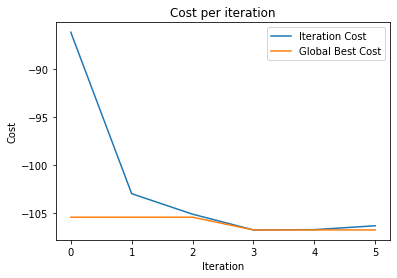

(-106.72561017633234, array([-1.60812206, -3.1431941 ]))

In [192]:
def bird(X):
  x,y = X
  return np.sin(x)*(np.exp(1-np.cos(y))**2)+np.cos(y)*(np.exp(1-np.sin(x))**2)+(x-y)**2

minD=[-2*np.pi,-2*np.pi]
maxD=[2*np.pi,2*np.pi]

opti=FHO(minD , maxD, N=200, function = bird, max_iter=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b